# Exposure Comparisons


In [1]:
# builds the connection to azure:
%matplotlib inline

import os
import sys

import numpy as np

import seaborn as sns

# import custom modules:
module_path = os.path.dirname(os.path.abspath(''))
if module_path not in sys.path:
    sys.path.append(module_path)
from common.get_data import *

#set colour palette for seaborn
colors = set_colours()
sns.set_palette(sns.color_palette(colors))
#get engine for sql queries
engine=get_engine()


In [2]:
# get model_version
model_version = pd.read_sql_query('''select value from model_metadata where item = 'model_version' ''', engine)
model_version = model_version.iloc[0][0]
model_version

'v2022.2.3'

## Event Data

In [3]:
df_events_raw = read_f1k_table().sort_values('event_start_date', ascending=True)
df_events_raw.tail()

,event_id,source_name,source_id,company_instance_id,insured_exposure,uninsured_exposure,event_type,event_name,event_start_date,is_event_start_date_estimated,...,company_type,company_naics,company_sic,company_industry,company_parent_name,company_parent_domain,company_ultimate_parent_name,company_ultimate_parent_domain,company_created_at,year_start
3454,4403,['audit_analytics'],['877'],58028,NaN,NaN,['Data Breach'],None,2020-12-24,False,...,None,445110.0,5411.0,Grocery stores,None,None,None,None,2022-05-11 15:28:07.203389,2020
2584,4402,['advisen'],['177973' '177974'],57082,NaN,NaN,['Data Breach'],The Kroger Co. Data Malicious Breach 2020,2020-12-24,False,...,None,445110.0,5411.0,Grocery stores,None,None,None,None,2022-05-11 15:28:07.203389,2020
1601,23678,['advisen'],['164462' '163959'],52672,NaN,NaN,['Ransomware'],"Carnival Corporation Ransomware Attack, 2020",2020-12-25,False,...,None,483112.0,4481.0,"Deep sea transportation of passengers, except ...",None,None,None,None,2022-05-11 15:28:07.203389,2020
937,36792,['advisen' 'audit_analytics'],['175847' '898' '140580'],57997,NaN,NaN,['Data Breach'],"CSX Transportation, Inc, Cl0p Ransomware Attac...",2020-12-25,False,...,None,482111.0,4011.0,"Railroads, line-haul operating",None,None,None,None,2022-05-11 15:28:07.203389,2020
184,56971,['advisen'],['145352' '145549'],56915,NaN,NaN,['Data Breach'],"Washington University School of Medicine, Unau...",2020-12-27,False,...,None,622110.0,8062.0,General medical and surgical hospitals,None,None,None,None,2022-05-11 15:28:07.203389,2020


In [4]:
df_events_filtered = df_events_raw.groupby('company_name').agg({'company_revenue_millions_usd':'last',
                                           'company_sic':'last',
                                           'company_state':'last',}).reset_index()
df_events_filtered.tail()

,company_name,company_revenue_millions_usd,company_sic,company_state
380,Yale University,4246.930,8221.0,CT
381,Yum Brands Inc,6584.000,5812.0,KY
382,"Zillow, Inc",3339.817,7372.0,WA
383,"Zions Bancorporation, National Association /Ut/",3046.000,6021.0,UT
384,Zoom Video Communications Inc,2651.368,7371.0,CA


In [5]:
df_events = df_events_filtered[['company_name','company_revenue_millions_usd','company_sic','company_state']]
df_events = df_events.rename({'company_name':'company_name',
                 'company_revenue_millions_usd':'revenue',
                 'company_sic':'sic',
                 'company_state':'geography',
                 }, axis='columns')
df_events['sic'] = df_events['sic'].apply(lambda x: str(int(x))[:2],2).astype(int)
df_events['source'] = 'data'

## Model Data

In [6]:
# get model_data
df_model = pd.read_sql_query('''
    select
        entity_name as company_name,
        entity_revenue/1e6 as revenue,
        sic_code as sic,
        countries as geography
    from
        model_entities
''', engine)

df_model['geography'] = df_model['geography'].str.replace('US-','')
df_model['source'] = 'model'
df_model.tail()

,company_name,revenue,sic,geography,source
944,Deluxe,2008.7,78,MN,model
945,Mr. Cooper Group,2007.0,60,TX,model
946,Healthpeak Properties,1997.4,60,CA,model
947,SPX FLOW,1996.3,35,NC,model
948,Liberty Oilfield Services,1990.3,13,CO,model


## Join data sets

In [7]:
data = pd.concat([df_model, df_events]).reset_index()


## Compare Revenue

(-1.0, 100000.0)

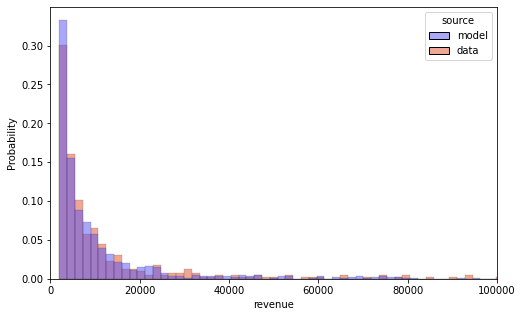

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.histplot(data=data, x='revenue', hue='source', common_norm=False, stat='probability')
ax.set_xlim(-1, 100000)

## Compare SIC

In [9]:
data_sic = data.groupby(['source','sic'])['company_name'].agg('count').reset_index()
data_sic['sic'] = data_sic['sic'].astype(int)
data_sic.rename({'company_name':'entitiy_count'}, axis='columns', inplace=True)

In [10]:
#add in mapping of SIC and descriptions/divisions

sic_map = pd.read_csv(module_path + '/resources/SIC_code_map.csv')
data_sic = data_sic.merge(sic_map, how='left', left_on='sic', right_on='SIC Code')
data_sic.head(5)

,source,sic,entitiy_count,Division Desc.,Division,Code Desc.,Code Desc. Short,SIC Code,CRA_SIC
0,data,15,2,Construction,C,Building Construction General Contractors And ...,Building Contractors,15,C_15
1,data,16,1,Construction,C,Heavy Construction Other Than Building Constru...,Heavy Construction Contractors,16,C_16
2,data,17,2,Construction,C,Construction Special Trade Contractors,Special Trade Contractors,17,C_17
3,data,20,8,Manufacturing,D,Food And Kindred Products,Food And Kindred Manuf.,20,D_20
4,data,22,1,Manufacturing,D,Textile Mill Products,Textile Manuf.,22,D_22


In [11]:
# Normalise the counts
data_sic['source_total'] = 0
data_sic.loc[data_sic['source']=='data', 'source_total'] = data_sic.loc[data_sic['source']=='data', 'entitiy_count'].sum()
data_sic.loc[data_sic['source']=='model', 'source_total'] = data_sic.loc[data_sic['source']=='model', 'entitiy_count'].sum()

data_sic['entity_count_normalised'] = data_sic['entitiy_count']/data_sic['source_total']
data_sic[['source','entity_count_normalised']].groupby('source').agg('sum')

,entity_count_normalised
source,
data,1.0
model,1.0


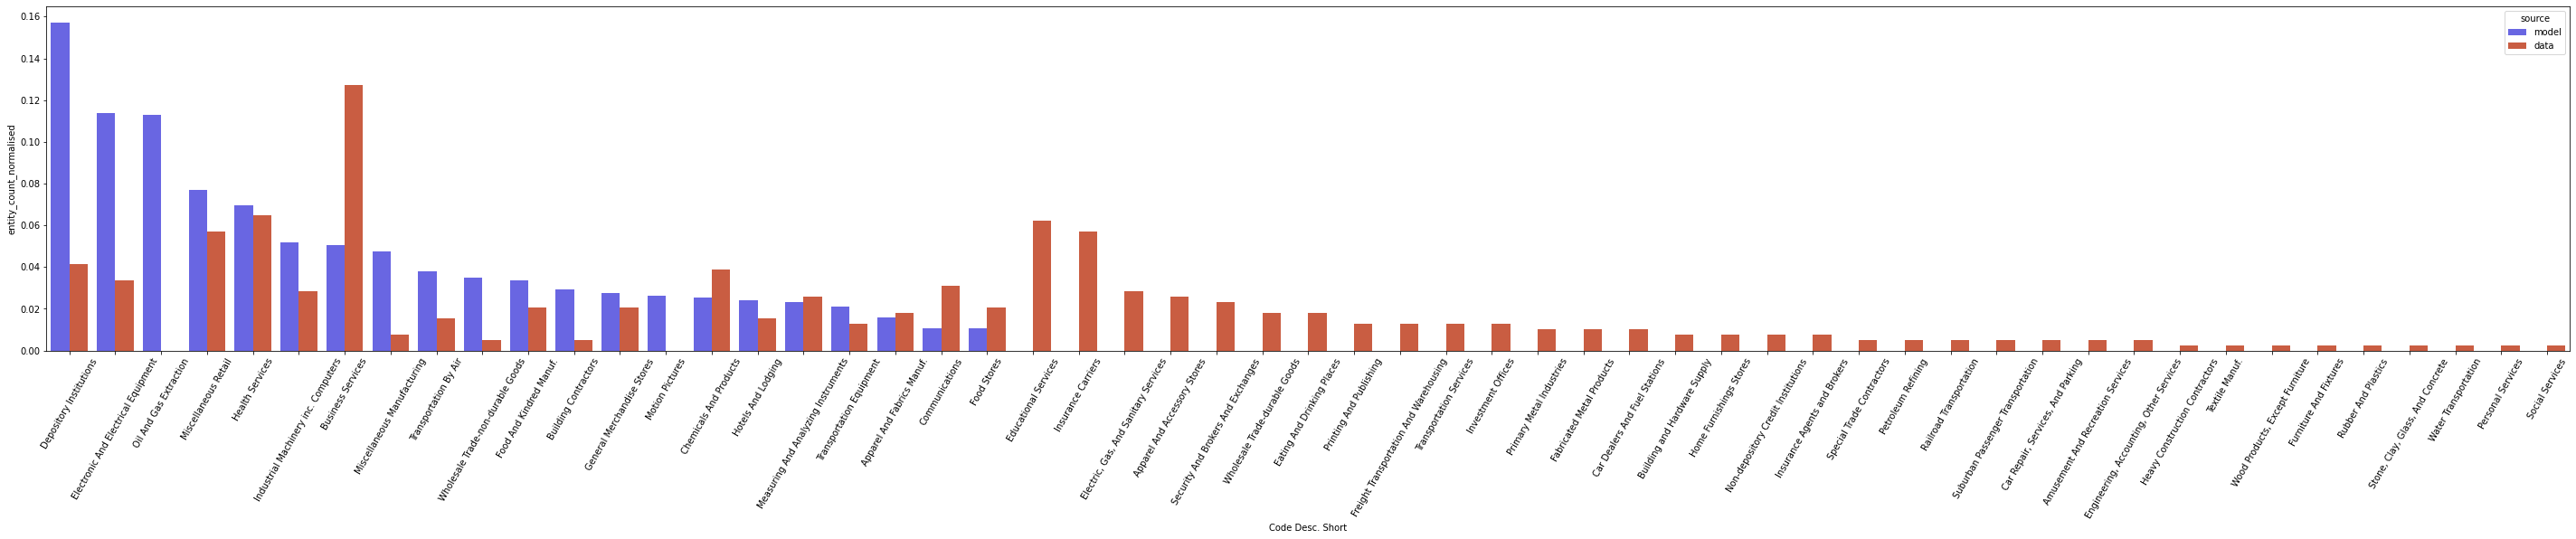

In [12]:
fig, ax = plt.subplots(1,1,figsize=(50,7))
sns.barplot(data=data_sic.sort_values(['source', 'entity_count_normalised'], ascending=False), x='Code Desc. Short', y='entity_count_normalised', hue='source')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
fig.show()

### Add in Division

In [13]:
data_sic_div = data_sic.groupby(['source','Division Desc.'])['entity_count_normalised'].agg('sum').reset_index()
data_sic_div

,source,Division Desc.,entity_count_normalised
0,data,Construction,0.012987
1,data,"Finance, Insurance, And Real Estate",0.150649
2,data,Manufacturing,0.238961
3,data,Retail Trade,0.168831
4,data,Services,0.290909
5,data,Utilities and Services,0.114286
6,data,Wholesale Trade,0.023377
7,model,Construction,0.029505
8,model,"Finance, Insurance, And Real Estate",0.157007
9,model,Manufacturing,0.331928


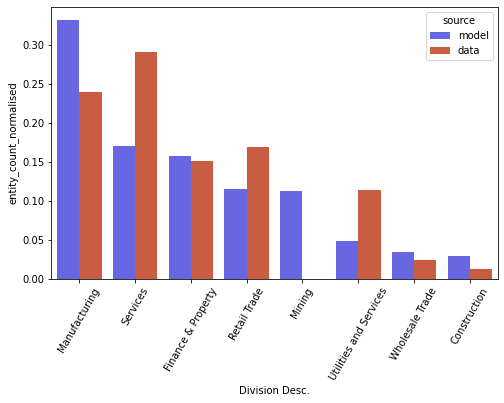

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
data_sic_div['Division Desc.'].replace('Finance, Insurance, And Real Estate','Finance & Property', inplace=True)
sns.barplot(data=data_sic_div.sort_values(['source', 'entity_count_normalised'], ascending=False), x='Division Desc.', y='entity_count_normalised', hue='source')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
fig.show()

## Compare Geography

In [15]:
data_geo = data.groupby(['source','geography'])['company_name'].agg('count').reset_index()
data_geo.rename({'company_name':'entitiy_count'}, axis='columns', inplace=True)
data_geo

,source,geography,entitiy_count
0,data,AL,1
1,data,AR,4
2,data,AZ,8
3,data,CA,60
4,data,CO,4
...,...,...,...
80,model,UT,2
81,model,VA,32
82,model,VT,1
83,model,WA,15


In [16]:
data_geo['source_total'] = 0
data_geo.loc[data_geo['source']=='data', 'source_total'] = data_geo.loc[data_geo['source']=='data', 'entitiy_count'].sum()
data_geo.loc[data_geo['source']=='model', 'source_total'] = data_geo.loc[data_geo['source']=='model', 'entitiy_count'].sum()

data_geo['entity_count_normalised'] = data_geo['entitiy_count']/data_geo['source_total']
data_geo[['source','entity_count_normalised']].groupby('source').agg('sum')

,entity_count_normalised
source,
data,1.0
model,1.0


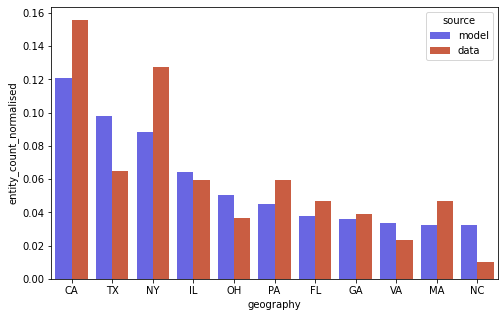

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(data=data_geo.sort_values(['source', 'entity_count_normalised'], ascending=False), x='geography', y='entity_count_normalised', hue='source')
ax.set_xlim(-0.5, 10.5)
fig.show()
